In [1]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import GPy
import GPyOpt

## Introduction

In this notebook, we will compare three different methods of hyperparameter tuning: Hyperband, Random Search and Bayesian Optimisation. The comparison is made on the four hyperparameter logistic model from [[Snoek, 2012]](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf). 

For more info about Hyperband:
 - [Hyperband paper](https://arxiv.org/pdf/1603.06560.pdf)
 - [Useful blog post](https://people.eecs.berkeley.edu/~kjamieson/hyperband.html)
 - [Combining BayesOpt with Hyperband](https://bayesopt.github.io/papers/2017/36.pdf)

## Import MNIST regression problem 

In [2]:
from MNIST_problem import *
problem = MNIST_problem()
problem.print_domain()

[   {'domain': (-6, 0), 'name': 'gamma_log', 'type': 'continuous'},
    {'domain': (-6, 0), 'name': 'alpha_log', 'type': 'continuous'},
    {'domain': (5, 1000), 'name': 'n_iter', 'type': 'continuous'},
    {'domain': (20, 2000), 'name': 'batch_size', 'type': 'continuous'}]


## Hyperband, Random Search and Bayesian Optimisation

In [ ]:
from HyperbandOptimiser import *
hyperband_opt = HyperbandOptimiser(problem.f, problem.domain)
hyperband_opt.run_optimization(max_iter = 1024, verbosity = True)

In [4]:
time_budget = hyperband_opt.checkpoints[-1]
print("Time budget = {}".format(time_budget))

Time budget = 4988.03750872612


In [ ]:
from RandomOptimiser import *
random_opt = RandomOptimiser(problem.f, problem.domain)
random_opt.run_optimization(max_time = time_budget, verbosity=True)

In [6]:
# Prepare seed for Bayesian Opt based on random design
n_initial = 20
X_init = random_opt.X[:n_initial,:]
Y_init = random_opt.Y[:n_initial,:]
time_init = random_opt.checkpoints[n_initial]
print(time_init)

1354.4428300857544


In [7]:
bayes_opt = GPyOpt.methods.BayesianOptimization(f = problem.f,                   
                                                domain = problem.domain, 
                                                X = X_init,
                                                Y = Y_init,
                                                model_type = 'GP',
                                                acquisition_type = 'EI',
                                                exact_feval = True,
                                                initial_design_numdata = 0,
                                                num_cores = 2)  

In [ ]:
bayes_opt.run_optimization(max_iter = None,  max_time = time_budget-time_init, verbosity = True)

In [9]:
# Perform editing on bayes_opt checkpoints to include initial design
for i in range(len(bayes_opt.checkpoints)):
    bayes_opt.checkpoints[i] += time_init
bayes_opt.checkpoints = random_opt.checkpoints[:n_initial] + bayes_opt.checkpoints

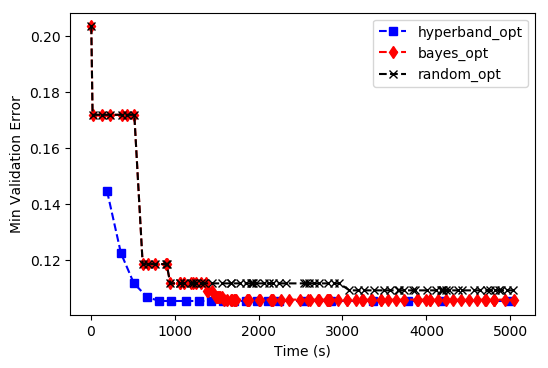

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.plot(hyperband_opt.checkpoints, hyperband_opt.Y_best, '--bs', label='hyperband_opt')
ax.plot(bayes_opt.checkpoints, bayes_opt.Y_best, '--rd', label='bayes_opt')
ax.plot(random_opt.checkpoints, random_opt.Y_best, '--kx', label='random_opt')
plt.ylabel('Min Validation Error'); plt.xlabel('Time (s)');
plt.legend()

In [11]:
def printOptimalResults(optimiser):
    min_index = np.argmin(optimiser.Y)
    x_best = optimiser.X[min_index,:]
    f_best = optimiser.Y[min_index]
    print(x_best)
    print(f_best)

In [12]:
printOptimalResults(random_opt)

[   -5.79381286    -4.50253884   950.74549155  1955.87246499]
[ 0.109]


In [13]:
printOptimalResults(bayes_opt)

[   -6.            -4.81437482   135.08124303  1629.79498667]
[ 0.1057]


In [15]:
printOptimalResults(hyperband_opt)

[   -5.95878044    -5.59769088   256.          1677.60567449]
[ 0.1052]
